In [1]:
# Most Basic
import sys
from arch import arch_model

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas as pd
import numpy as np
import math
import scipy.stats as ss
import copy
import warnings
import datetime as dt
from os import path
from datetime import datetime
from scipy.stats import norm
from DataMaker_New import dataCleaner_new

warnings.simplefilter('ignore')

In [2]:
# Define transition Dynamics
# Positional requirement, no real effect, will be replaced by ESN and BS defined further down
def fx(x, dt):
    return x*dt
def hx(x):
    return x

def sigmoid(x):
    return np.divide(1, 1+np.exp(-x))


def ESNf(theta_now, dt, **fx_args):
    """
    :params theta_now theta_t
    
    **fx_args
    :params G reservoir transition matrix
    :params G_in input translation matrix
    :params b reservoir bias vector
    :params u_quad_now u_t^2
    """
    G = fx_args["G"]
    G_in = fx_args["G_in"]
    b = fx_args["b"]
    u_quad_now = fx_args["u_quad_now"]
    theta_next = sigmoid(np.matmul(G, theta_now) + np.matmul(G_in, u_quad_now) + b)
    return theta_next
    

def BSf(theta_t, **hx_args):
    """
    :params theta_t current state vector
    
    **hx_args
    :params p_t current asset price
    :params r_t current asset price
    :params K_t strike price, 1d vector
    :params T_t maturity time, 1d vector
    """
    p_t = hx_args["p_t"]
    r_t = hx_args["r_t"]
    K_t = hx_args["K_t"]
    T_t = hx_args["T_t"]
    
    volatility_std = np.average(theta_t)
    volatility_var = np.power(volatility_std, 2)
    
    dividor = np.sqrt(volatility_var * T_t)
    d_pls = (np.log(p_t/K_t) + np.multiply(r_t+volatility_var/2, T_t)) / dividor
    d_mns = (np.log(p_t/K_t) + np.multiply(r_t-volatility_var/2, T_t)) / dividor
    y_t = np.multiply(p_t, norm.cdf(d_pls)) - np.multiply(np.multiply(K_t, np.exp(-r_t*T_t)), norm.cdf(d_mns))
    return y_t

def is_pos_def(x):
    return np.all(np.linalg.eigvals(x) > 0)


# Test Implied Volatility

Attached 225 days of train data
Attached 1125 train option observations
Attached 75 days of validation data
Attached 375 validation option observations
Attached 75 days of test data
Attached 375 test option observations
[              date     exdate  strike_price  best_bid  best_offer  volume  \
6185579 2018-01-02 2018-01-26        2690.0      22.2        22.8   20602   
6185583 2018-01-02 2018-01-26        2710.0      10.7        11.1   19951   
6185572 2018-01-02 2018-01-26        2655.0      49.6        50.4   19678   
6185576 2018-01-02 2018-01-26        2675.0      33.2        33.9   19647   
6183070 2018-01-02 2018-03-16        2690.0      44.4        45.3   18201   

         impl_volatility  spotclose  
6185579         0.070124      22.50  
6185583         0.061341      10.90  
6185572         0.088180      50.00  
6185576         0.077890      33.55  
6183070         0.086415      44.85  , 0.0169693, array([ 0.00536281, -0.00323027, -0.00082789,  0.00198566, -0.00045817,
    

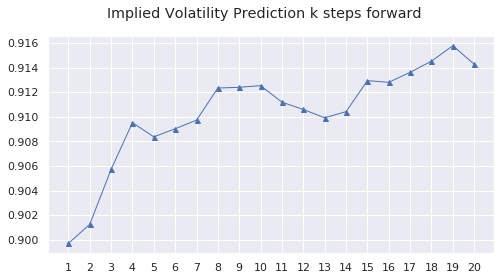

In [5]:
columns = ["date","exdate","strike_price","best_bid","best_offer","volume","impl_volatility"]
start = dt.datetime(2018, 1, 1)
end = dt.datetime(2019, 12, 31)
train_valid_split = 0.6
valid_test_split = 0.8
u_dim = 10
topK = 5
cleaner = dataCleaner_new(columns, u_dim, topK, start, end, train_valid_split, valid_test_split)
return_dict, price_dict = cleaner.make_return_price()
risk_dict = cleaner.make_risk()
train_data, valid_data, test_data = cleaner.make_final_data(price_dict, return_dict, risk_dict)
num_train_day, num_train_obs = cleaner.get_train_num()
num_valid_day, num_valid_obs = cleaner.get_valid_num()
num_test_day, num_test_obs = cleaner.get_test_num()

print(train_data[np.datetime64('2018-01-02T00:00:00.000000000')])

bday_p_year = 252
forward_k = 20
base_date = list(valid_data.keys())[-1]
base_date_vol = np.average(valid_data[list(valid_data.keys())[-1]][0]["impl_volatility"].values) / bday_p_year

test_days = list(test_data.keys())
test_error_traj_imp_vol = []
for k in range(1, min(forward_k+1, num_test_day+1)):
    k_step_test_error_imp_vol = []
    for idx in range(k-1, num_test_day):
        pred_date = test_days[idx]
        pred_date_p = test_data[pred_date][3]
        pred_date_r = test_data[pred_date][1] 
        pred_date_K = test_data[pred_date][0]["strike_price"].values
        today = [d.date() for d in test_data[pred_date][0]["date"]]
        expireday = [d.date() for d in test_data[pred_date][0]["exdate"]]
        pred_date_T = np.busday_count(today, expireday) / bday_p_year
        pred_date_y = test_data[pred_date][0]["spotclose"].values

        pred_price_imp_vol = BSf(base_date_vol, 
                                 p_t=pred_date_p, 
                                 r_t=pred_date_r, 
                                 K_t=pred_date_K, 
                                 T_t=pred_date_T)
        pred_error_imp_vol = np.average(np.abs(pred_price_imp_vol-pred_date_y) / pred_date_y)
        k_step_test_error_imp_vol.append(pred_error_imp_vol)

        base_date = test_days[idx-k+1]
        base_date_vol = np.average(valid_data[list(valid_data.keys())[-1]][0]["impl_volatility"].values) / bday_p_year

    test_error_traj_imp_vol.append(np.average(k_step_test_error_imp_vol))

%matplotlib inline
sns.set()
fig = plt.figure(figsize=(8,4))
xlabel = list(range(len(test_error_traj_imp_vol)+1))
fig.suptitle("Implied Volatility Prediction k steps forward")
plt.xticks(xlabel)
plt.plot([_+1 for _ in range(forward_k)], test_error_traj_imp_vol, marker ='^', markersize=5, linewidth=1)

fig.show()

# Test GARCH family

In [4]:
columns = ["date","exdate","strike_price","best_bid","best_offer","volume","impl_volatility"]
start = dt.datetime(2018, 1, 1)
end = dt.datetime(2019, 12, 31)
train_valid_split = 0.936
valid_test_split = 0.94
u_dim = 1
topK = 5
cleaner = dataCleaner_new(columns, u_dim, topK, start, end, train_valid_split, valid_test_split)
return_dict, price_dict = cleaner.make_return_price()
risk_dict = cleaner.make_risk()
train_data, valid_data, test_data = cleaner.make_final_data(price_dict, return_dict, risk_dict)
num_train_day, num_train_obs = cleaner.get_train_num()
num_valid_day, num_valid_obs = cleaner.get_valid_num()
num_test_day, num_test_obs = cleaner.get_test_num()

from IPython.utils import io

# Too much output from the ARCH package. Therefore I disabled it. You can show all the output by disableing the io.capture_output() environment
with io.capture_output() as captured:

    returns = []
    index = []
    for day in list(train_data.keys()):
        returns.append(train_data[day][2][0])
        index.append(day)
    for day in list(valid_data.keys()):
        returns.append(valid_data[day][2][0])
        index.append(day)
    last_val_date = list(valid_data.keys())[-1]
    last_val_date_idx = len(index)-1

    for day in list(test_data.keys()):
        returns.append(test_data[day][2][0])
        index.append(day)
    returns = np.array(returns)*100
    index = np.array(index)
    Garch_data = pd.DataFrame(returns, index=index, columns=["Returns"])


    test_error_traj_garch = []
    for k in range(1, min(forward_k+1, num_test_day+1)):
        k_step_test_error_garch = []
        base_idx = last_val_date_idx
        for idx in range(base_idx+k, len(index)):
            am = arch_model(Garch_data[:base_idx+1], vol='Garch', p=5, q=5, dist='Normal')
            res = am.fit(update_freq=10);
            forecasts = res.forecast(horizon=k)
            pred_vol = math.sqrt(forecasts.mean.iloc[-1].tolist()[-1] / 10000)

            pred_date = index[idx]
            pred_date_p = test_data[pred_date][3]
            pred_date_r = test_data[pred_date][1] / bday_p_year
            pred_date_K = test_data[pred_date][0]["strike_price"].values
            today = [d.date() for d in test_data[pred_date][0]["date"]]
            expireday = [d.date() for d in test_data[pred_date][0]["exdate"]]
            pred_date_T = np.busday_count(today, expireday)
            pred_date_y = test_data[pred_date][0]["spotclose"].values

            pred_price_garch = BSf(pred_vol,
                                   p_t=pred_date_p, 
                                   r_t=pred_date_r, 
                                   K_t=pred_date_K, 
                                   T_t=pred_date_T)

            pred_error_garch = np.average(np.abs(pred_price_garch-pred_date_y) / pred_date_y)

            k_step_test_error_garch.append(pred_error_garch)
            base_idx += 1

        test_error_traj_garch.append( np.average(k_step_test_error_garch ))



Attached 351 days of train data
Attached 1755 train option observations
Attached 1 days of validation data
Attached 5 validation option observations
Attached 23 days of test data
Attached 115 test option observations


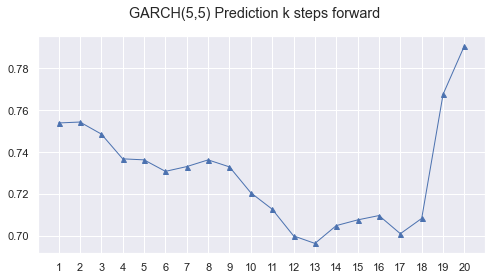

In [5]:
sns.set()
fig = plt.figure(figsize=(8,4))
xlabel = list(range(len(test_error_traj_garch)+1))
fig.suptitle("GARCH(5,5) Prediction k steps forward")
plt.xticks(xlabel)
plt.plot([_+1 for _ in range(forward_k)], test_error_traj_garch, marker ='^', markersize=5, linewidth=1)
fig.show()

# Test LSTM

In [86]:
columns = ["date","exdate","strike_price","best_bid","best_offer","volume","impl_volatility"]
start = dt.datetime(2018, 1, 1)
end = dt.datetime(2019, 12, 31)
train_valid_split = 0.936
valid_test_split = 0.94
u_dim = 5
topK = 7
cleaner = dataCleaner_new(columns, u_dim, topK, start, end, train_valid_split, valid_test_split)
return_dict, price_dict = cleaner.make_return_price()
risk_dict = cleaner.make_risk()
train_data, valid_data, test_data = cleaner.make_final_data(price_dict, return_dict, risk_dict)
num_train_day, num_train_obs = cleaner.get_train_num()
num_valid_day, num_valid_obs = cleaner.get_valid_num()
num_test_day, num_test_obs = cleaner.get_test_num()

train_data[np.datetime64('2019-01-02T00:00:00.000000000')]

Attached 351 days of train data
Attached 2457 train option observations
Attached 1 days of validation data
Attached 7 validation option observations
Attached 23 days of test data
Attached 161 test option observations


[              date     exdate  strike_price  best_bid  best_offer  volume  \
 7824298 2019-01-02 2019-06-21        3050.0      3.40         3.7   30005   
 7824308 2019-01-02 2019-06-21        3300.0      0.75         1.0   30005   
 7823256 2019-01-02 2019-01-18        2570.0     14.50        15.3   22363   
 7823260 2019-01-02 2019-01-18        2590.0      9.20         9.8   19735   
 7825956 2019-01-02 2019-01-11        2525.0     23.40        24.0   19555   
 7823594 2019-01-02 2019-02-15        2620.0     21.90        22.7   19190   
 7823603 2019-01-02 2019-02-15        2665.0     11.70        12.3   19159   
 
          impl_volatility  spotclose  
 7824298         0.149985      3.550  
 7824308         0.163895      0.875  
 7823256         0.180783     14.900  
 7823260         0.174487      9.500  
 7825956         0.192232     23.700  
 7823594         0.174624     22.300  
 7823603         0.167458     12.000  ,
 0.0279388,
 array([ 0.04959374,  0.00856268, -0.00124158,  0

In [101]:
# Make train and test data
X_train = [] # (num_train_day, topK, input information dim)
Y_train = [] # (num_train_day, topK, 1)
for day in list(train_data.keys()):
    # get observable data
    ## Stock Wise and market wise data
    u_t = train_data[day][2].reshape([1, -1])
    r_t = (train_data[day][1]).reshape([1, -1])
    r_t_indata = np.repeat(r_t, topK, axis=0)
    u_quad_t = np.power(u_t, 2)
    u_quad_indata = np.repeat(u_quad_t, topK, axis=0)
    p_t = train_data[day][3].reshape([1,-1])
    p_t_indata = np.repeat(p_t, topK, axis=0)
    
    ## Option wise data
    K_t = train_data[day][0]["strike_price"].values.reshape([topK, 1])
    today = [d.date() for d in train_data[day][0]["date"]]
    expireday = [d.date() for d in train_data[day][0]["exdate"]]
    T_t = np.busday_count(today, expireday).reshape([topK, 1])
    
    #[u_quad_t, p_t, r_t, K_t, T_t]
    x_day_data = np.concatenate((u_quad_indata, p_t_indata, r_t_indata, K_t, T_t), axis = 1)
    y_day_data = train_data[day][0]["spotclose"].values.reshape([topK, 1])
    
    X_train.append(x_day_data)
    Y_train.append(y_day_data)

X_train = np.array(X_train)
Y_train = np.array(Y_train)


X_test = [] # (num_valid_day+num_test_day, topK, input information dim)
Y_test = [] # (num_valid_day+num_test_day, topK, 1)
for day in list(valid_data.keys()):
    # get observable data
    ## Stock Wise and market wise data
    u_t = valid_data[day][2].reshape([1, -1])
    r_t = (valid_data[day][1]).reshape([1, -1])
    r_t_indata = np.repeat(r_t, topK, axis=0)
    u_quad_t = np.power(u_t, 2)
    u_quad_indata = np.repeat(u_quad_t, topK, axis=0)
    p_t = valid_data[day][3].reshape([1,-1])
    p_t_indata = np.repeat(p_t, topK, axis=0)
    
    ## Option wise data
    K_t = valid_data[day][0]["strike_price"].values.reshape([topK, 1])
    today = [d.date() for d in valid_data[day][0]["date"]]
    expireday = [d.date() for d in valid_data[day][0]["exdate"]]
    T_t = np.busday_count(today, expireday).reshape([topK, 1])
    
    #[u_quad_t, p_t, r_t, K_t, T_t]
    x_day_data = np.concatenate((u_quad_indata, p_t_indata, r_t_indata, K_t, T_t), axis = 1)
    y_day_data = valid_data[day][0]["spotclose"].values.reshape([topK, 1])
    
    X_test.append(x_day_data)
    Y_test.append(y_day_data)

for day in list(test_data.keys()):
    # get observable data
    ## Stock Wise and market wise data
    u_t = test_data[day][2].reshape([1, -1])
    r_t = (test_data[day][1]).reshape([1, -1])
    r_t_indata = np.repeat(r_t, topK, axis=0)
    u_quad_t = np.power(u_t, 2)
    u_quad_indata = np.repeat(u_quad_t, topK, axis=0)
    p_t = test_data[day][3].reshape([1,-1])
    p_t_indata = np.repeat(p_t, topK, axis=0)
    
    ## Option wise data
    K_t = test_data[day][0]["strike_price"].values.reshape([topK, 1])
    today = [d.date() for d in test_data[day][0]["date"]]
    expireday = [d.date() for d in test_data[day][0]["exdate"]]
    T_t = np.busday_count(today, expireday).reshape([topK, 1])
    
    #[u_quad_t, p_t, r_t, K_t, T_t]
    x_day_data = np.concatenate((u_quad_indata, p_t_indata, r_t_indata, K_t, T_t), axis = 1)
    y_day_data = test_data[day][0]["spotclose"].values.reshape([topK, 1])
    
    X_test.append(x_day_data)
    Y_test.append(y_day_data)

X_test = np.array(X_test)
Y_test = np.array(Y_test)

# X_train = np.swapaxes(X_train, 0, 1)
# Y_train = np.swapaxes(Y_train, 0, 1)
# X_test = np.swapaxes(X_test, 0, 1)
# Y_test = np.swapaxes(Y_test, 0, 1)


batch_size = X_train.shape[0]
seq_length = X_train.shape[1]
input_dim = X_train.shape[2]

print(X_train.shape)

(351, 7, 9)


In [115]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Dropout

Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_39 (LSTM)               (None, 512)               1069056   
_________________________________________________________________
dense_33 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_8 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_34 (Dense)             (None, 7)                 1799      
Total params: 1,202,183
Trainable params: 1,202,183
Non-trainable params: 0
_________________________________________________________________
None


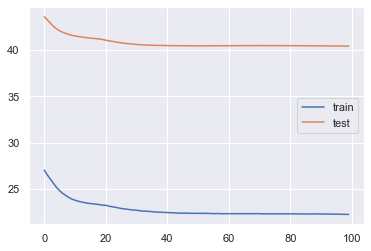

[[14.312889  12.6078    10.814424  ... 13.3874855 14.465047  12.398092 ]
 [14.27231   12.597726  10.830504  ... 13.421013  14.431598  12.323626 ]
 [14.287427  12.616262  10.840289  ... 13.393361  14.47972   12.574887 ]
 ...
 [14.298431  12.598659  10.824788  ... 13.398061  14.461564  12.573114 ]
 [14.298159  12.534722  10.735629  ... 13.391341  14.432278  12.237711 ]
 [14.397185  12.634934  10.779649  ... 13.289768  14.591878  13.020808 ]]
[[[22.5  ]
  [10.9  ]
  [50.   ]
  ...
  [44.85 ]
  [ 2.45 ]
  [ 5.1  ]]

 [[22.8  ]
  [42.5  ]
  [18.75 ]
  ...
  [19.15 ]
  [ 7.1  ]
  [10.35 ]]

 [[40.15 ]
  [ 2.   ]
  [27.95 ]
  ...
  [ 6.8  ]
  [ 1.2  ]
  [31.05 ]]

 ...

 [[11.65 ]
  [41.55 ]
  [ 2.4  ]
  ...
  [ 3.6  ]
  [ 1.325]
  [44.65 ]]

 [[ 8.55 ]
  [ 0.5  ]
  [ 9.7  ]
  ...
  [ 1.775]
  [48.95 ]
  [ 6.05 ]]

 [[43.05 ]
  [46.05 ]
  [ 2.55 ]
  ...
  [31.85 ]
  [11.25 ]
  [33.35 ]]]


In [134]:
model = Sequential()
model.add(LSTM(512, input_shape=(X_train.shape[1], X_train.shape[2])))
# model.add(LSTM(256, input_shape=(X_train.shape[1], 512)))
model.add(Dense(256, activation='tanh'))
model.add(Dropout(0.1, input_shape=(256,)))
model.add(Dense(topK, activation='relu'))
model.compile(loss='MAE', optimizer='adam')

print(model.summary())


history = model.fit(X_train, Y_train, epochs=100, batch_size=batch_size, validation_data=(X_test, Y_test), verbose=0, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

yhat = model.predict(X_train)
print(yhat)
print(Y_train)

In [81]:
from torch import nn, optim
import torch

In [84]:
# Here we define our model as a class
class LSTM(nn.Module):

    def __init__(self, input_dim, hidden_dim, batch_size, output_dim, num_layers=2):
        super(LSTM, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.num_layers = num_layers

        # Define the LSTM layer
        self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers)

        # Define the output layer
        self.linear = nn.Linear(self.hidden_dim, output_dim)

    def init_hidden(self):
        # This is what we'll initialise our hidden state as
        return (torch.zeros(self.num_layers, self.batch_size, self.hidden_dim),
                torch.zeros(self.num_layers, self.batch_size, self.hidden_dim))

    def forward(self, input):
        # Forward pass through LSTM layer
        # shape of lstm_out: [input_size, batch_size, hidden_dim]
        # shape of self.hidden: (a, b), where a and b both 
        # have shape (num_layers, batch_size, hidden_dim).
        input = torch.Tensor(input)
        lstm_out, self.hidden = self.lstm(input.view(len(input), self.batch_size, -1))
        print(lstm_out.shape)
        
        # Only take the output from the final timetep
        # Can pass on the entirety of lstm_out to the next layer if it is a seq2seq prediction
        y_pred = self.linear(lstm_out[-1].view(self.batch_size, -1))
        print(y_pred.view(-1))
        return y_pred.view(-1)

In [85]:
lstm_model = LSTM(input_dim, 16, batch_size=topK, output_dim=topK, num_layers=2)

loss_fn = torch.nn.MSELoss(size_average=False)

optimiser = torch.optim.Adam(lstm_model.parameters(), lr=0.02)

#####################
# Train model
#####################

num_epochs = 10

hist = np.zeros(num_epochs)



for t in range(num_epochs):
    # Clear stored gradient
    lstm_model.zero_grad()
    
    # Initialise hidden state
    # Don't do this if you want your LSTM to be stateful
    lstm_model.hidden = lstm_model.init_hidden()
    
    # Forward pass
    Y_pred = lstm_model(X_train)
    
    
    loss = loss_fn(Y_pred, Y_train)
    if t % 100 == 0:
        print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    # Zero out gradient, else they will accumulate between epochs
    optimiser.zero_grad()

    # Backward pass
    loss.backward()

    # Update parameters
    optimiser.step()

TypeError: tuple indices must be integers or slices, not tuple